# Capítulo 9 · Regularización: Ridge y Lasso

**Objetivo:** aplicar técnicas de **regularización** para mejorar la estabilidad del modelo y manejar la multicolinealidad:

- **Ridge** (penalización L2) para estabilizar coeficientes.
- **Lasso** (penalización L1) para realizar selección automática de variables.
- Comparar con el modelo OLS base en términos de:
  - Coeficientes.
  - Complejidad del modelo.
  - Desempeño predictivo (**RMSE**, $R^2$).

Usaremos las **mismas variables candidatas** que en los capítulos anteriores.


## 9.1 Datos, variables seleccionadas y partición entrenamiento/prueba

Partimos del mismo dataset *Ames Housing* y usamos un criterio automático para seleccionar hasta 12 variables candidatas altamente correlacionadas con `SalePrice` y con baja colinealidad entre sí.


In [21]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

# Localizar dataset
CANDIDATE_PATHS = [Path('data/ames_housing.csv'), Path('AmesHousing.csv')]
for p in CANDIDATE_PATHS:
    if p.exists():
        DATA_PATH = p
        break
else:
    raise FileNotFoundError('No se encontró data/ames_housing.csv ni AmesHousing.csv')

df = pd.read_csv(DATA_PATH)

target = "SalePrice"

# Numéricas y limpieza de infinitos
num_df = df.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan)

# Pool de variables según correlación absoluta con SalePrice
corr_abs = num_df.corr(numeric_only=True)[target].dropna().abs().sort_values(ascending=False)
pool = [c for c in corr_abs.index if c != target][:15]

sel = []
for v in pool:
    if not sel:
        sel.append(v)
        continue
    ok = True
    for u in sel:
        r = abs(num_df[[v, u]].dropna().corr().iloc[0, 1])
        if r > 0.85:
            ok = False
            break
    if ok:
        sel.append(v)
    if len(sel) >= 12:
        break

data = num_df[[target] + sel].dropna()
X = data[sel].values
y = data[target].values

feature_names = sel

X.shape, y.shape, feature_names

((2748, 12),
 (2748,),
 ['Overall Qual',
  'Gr Liv Area',
  'Garage Cars',
  'Total Bsmt SF',
  '1st Flr SF',
  'Year Built',
  'Full Bath',
  'Year Remod/Add',
  'Garage Yr Blt',
  'Mas Vnr Area',
  'TotRms AbvGrd',
  'Fireplaces'])

Mostramos las variables candidatas y su correlación absoluta con `SalePrice`:

In [22]:
pd.DataFrame({
    "Variable": sel,
    "abs(corr SalePrice)": corr_abs[sel].values
}).round(3)

,Variable,abs(corr SalePrice)
0,Overall Qual,0.799
1,Gr Liv Area,0.707
2,Garage Cars,0.648
3,Total Bsmt SF,0.632
4,1st Flr SF,0.622
5,Year Built,0.558
6,Full Bath,0.546
7,Year Remod/Add,0.533
8,Garage Yr Blt,0.527
9,Mas Vnr Area,0.508


Realizamos una partición entrenamiento/prueba (70% / 30%):

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train.shape, X_test.shape

((1923, 12), (825, 12))

## 9.2 Modelo OLS base (sin regularización)

Ajustamos primero un modelo de regresión lineal clásico sin penalización para usarlo como **referencia**.


In [24]:
ols_skl = LinearRegression()
ols_skl.fit(X_train, y_train)

y_train_pred_ols = ols_skl.predict(X_train)
y_test_pred_ols = ols_skl.predict(X_test)

rmse_train_ols = np.sqrt(mean_squared_error(y_train, y_train_pred_ols))
rmse_test_ols = np.sqrt(mean_squared_error(y_test, y_test_pred_ols))
r2_train_ols = r2_score(y_train, y_train_pred_ols)
r2_test_ols = r2_score(y_test, y_test_pred_ols)

rmse_train_ols, rmse_test_ols, r2_train_ols, r2_test_ols

(np.float64(36199.70732578323),
 np.float64(34302.280689270854),
 0.7928837406644176,
 0.813620818779851)

Guardamos los coeficientes OLS (sin intercepto) para compararlos luego con Ridge y Lasso:

In [25]:
coef_ols = pd.Series(ols_skl.coef_, index=feature_names)
coef_ols.round(4)

Overall Qual      19413.9215
Gr Liv Area          50.3840
Garage Cars       14928.9791
Total Bsmt SF        20.7325
1st Flr SF           11.2901
Year Built          151.5614
Full Bath         -6644.2333
Year Remod/Add      359.5447
Garage Yr Blt        70.3224
Mas Vnr Area         32.6375
TotRms AbvGrd     -1917.0279
Fireplaces         8588.6569
dtype: float64

## 9.3 Estandarización de predictores

La regularización Ridge y Lasso requiere que las variables estén en **escala comparable**, por lo que estandarizamos:

- Media 0  
- Desviación estándar 1  


In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled[:3]

array([[-0.8483711 , -1.1762113 , -1.3322942 , -0.3348402 , -0.6442113 ,
        -0.07847238, -1.02952515,  0.83262602, -0.29724965, -0.40179443,
        -0.93524871, -0.95938847],
       [-0.11973438, -0.92537101,  0.22231851, -0.04715108, -0.32322843,
        -0.24825456,  0.7768406 , -0.96063509, -0.49561551, -0.04149524,
        -0.93524871, -0.95938847],
       [-0.8483711 , -1.20560664, -1.3322942 , -1.30803857, -0.68182648,
        -2.11585844, -1.02952515, -1.68763284, -1.88417655, -0.57648495,
        -0.93524871, -0.95938847]])

## 9.4 Ridge (penalización L2)

Usamos `RidgeCV` con validación cruzada y una malla de valores de $\alpha$ en escala logarítmica.


In [27]:
alphas_ridge = np.logspace(-3, 3, 30)

ridge_cv = RidgeCV(alphas=alphas_ridge)
ridge_cv.fit(X_train_scaled, y_train)

alpha_ridge_best = ridge_cv.alpha_
alpha_ridge_best

np.float64(92.36708571873865)

Evaluamos desempeño de Ridge y comparamos con OLS:

In [28]:
y_train_pred_ridge = ridge_cv.predict(X_train_scaled)
y_test_pred_ridge = ridge_cv.predict(X_test_scaled)

rmse_train_ridge = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))
rmse_test_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))
r2_train_ridge = r2_score(y_train, y_train_pred_ridge)
r2_test_ridge = r2_score(y_test, y_test_pred_ridge)

rmse_train_ridge, rmse_test_ridge, r2_train_ridge, r2_test_ridge

(np.float64(36281.2553095157),
 np.float64(34276.402249856335),
 0.7919495376688287,
 0.8139019302910604)

Coeficientes Ridge (en la escala estandarizada de los predictores):

In [29]:
coef_ridge = pd.Series(ridge_cv.coef_, index=feature_names)
coef_ridge.round(4)

Overall Qual      25074.4748
Gr Liv Area       21610.0694
Garage Cars        9355.1281
Total Bsmt SF      9103.1686
1st Flr SF         5437.8894
Year Built         4209.6329
Full Bath         -2093.6113
Year Remod/Add     7513.6876
Garage Yr Blt      2374.3883
Mas Vnr Area       6409.1573
TotRms AbvGrd      -498.3574
Fireplaces         6206.2802
dtype: float64

## 9.5 Lasso (penalización L1)

Lasso agrega una penalización L1 que puede llevar algunos coeficientes exactamente a 0, realizando **selección automática de variables**.
Usamos `LassoCV` con validación cruzada y una grilla de alphas.


In [30]:
alphas_lasso = np.logspace(-4, 1, 40)

lasso_cv = LassoCV(alphas=alphas_lasso, cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)

alpha_lasso_best = lasso_cv.alpha_
alpha_lasso_best

np.float64(10.0)

Evaluamos desempeño de Lasso y lo comparamos con OLS y Ridge:

In [31]:
y_train_pred_lasso = lasso_cv.predict(X_train_scaled)
y_test_pred_lasso = lasso_cv.predict(X_test_scaled)

rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
r2_test_lasso = r2_score(y_test, y_test_pred_lasso)

rmse_train_lasso, rmse_test_lasso, r2_train_lasso, r2_test_lasso

(np.float64(36199.73214825413),
 np.float64(34301.49138375624),
 0.7928834566212878,
 0.8136293959601474)

Coeficientes Lasso (escala estandarizada):

In [32]:
coef_lasso = pd.Series(lasso_cv.coef_, index=feature_names)
coef_lasso.round(4)

Overall Qual      26649.1629
Gr Liv Area       25643.7181
Garage Cars        9593.8912
Total Bsmt SF      9226.5711
1st Flr SF         4503.5636
Year Built         4455.7497
Full Bath         -3638.4054
Year Remod/Add     7410.5281
Garage Yr Blt      1765.9696
Mas Vnr Area       5977.2546
TotRms AbvGrd     -2936.7641
Fireplaces         5566.0129
dtype: float64

## 9.6 Comparación de coeficientes: OLS vs Ridge vs Lasso

Comparamos los coeficientes estimados por cada método para las mismas variables.


In [33]:
coef_comp = pd.DataFrame({
    "OLS": coef_ols,
    "Ridge": coef_ridge,
    "Lasso": coef_lasso,
})

coef_comp.round(4)

,OLS,Ridge,Lasso
Overall Qual,19413.9215,25074.4748,26649.1629
Gr Liv Area,50.3840,21610.0694,25643.7181
Garage Cars,14928.9791,9355.1281,9593.8912
Total Bsmt SF,20.7325,9103.1686,9226.5711
1st Flr SF,11.2901,5437.8894,4503.5636
Year Built,151.5614,4209.6329,4455.7497
Full Bath,-6644.2333,-2093.6113,-3638.4054
Year Remod/Add,359.5447,7513.6876,7410.5281
Garage Yr Blt,70.3224,2374.3883,1765.9696
Mas Vnr Area,32.6375,6409.1573,5977.2546


Gráfico de barras comparando coeficientes:

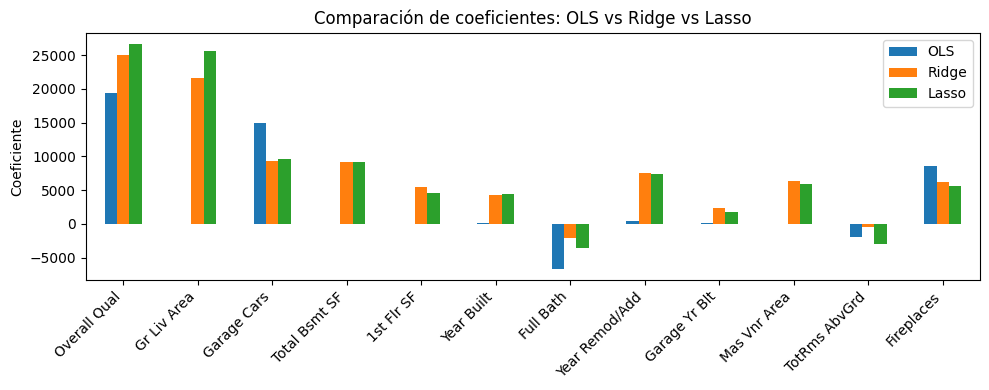

In [34]:
ax = coef_comp.plot(kind="bar", figsize=(10,4))
ax.set_ylabel("Coeficiente")
ax.set_title("Comparación de coeficientes: OLS vs Ridge vs Lasso")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 9.7 Comparación de desempeño predictivo

Construimos una tabla resumen con RMSE y $R^2$ en entrenamiento y prueba para cada método.


In [35]:
metrics_table = pd.DataFrame({
    "RMSE_train": [rmse_train_ols, rmse_train_ridge, rmse_train_lasso],
    "RMSE_test":  [rmse_test_ols,  rmse_test_ridge,  rmse_test_lasso],
    "R2_train":   [r2_train_ols,   r2_train_ridge,   r2_train_lasso],
    "R2_test":    [r2_test_ols,    r2_test_ridge,    r2_test_lasso],
}, index=["OLS", "Ridge", "Lasso"]).round(4)

metrics_table

,RMSE_train,RMSE_test,R2_train,R2_test
OLS,36199.7073,34302.2807,0.7929,0.8136
Ridge,36281.2553,34276.4022,0.7919,0.8139
Lasso,36199.7321,34301.4914,0.7929,0.8136


Gráfico comparando RMSE en el conjunto de prueba:

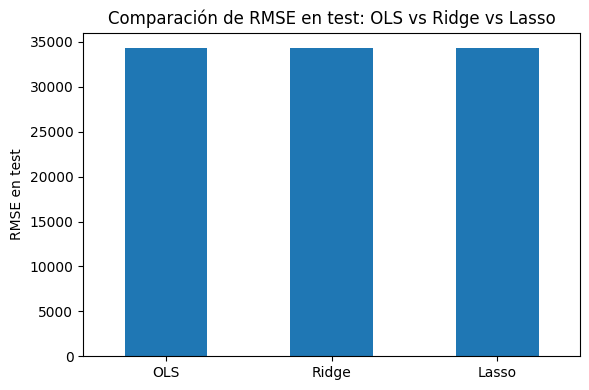

In [36]:
ax = metrics_table["RMSE_test"].plot(kind="bar", figsize=(6,4))
ax.set_ylabel("RMSE en test")
ax.set_title("Comparación de RMSE en test: OLS vs Ridge vs Lasso")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Y también comparamos el $R^2$ en prueba:

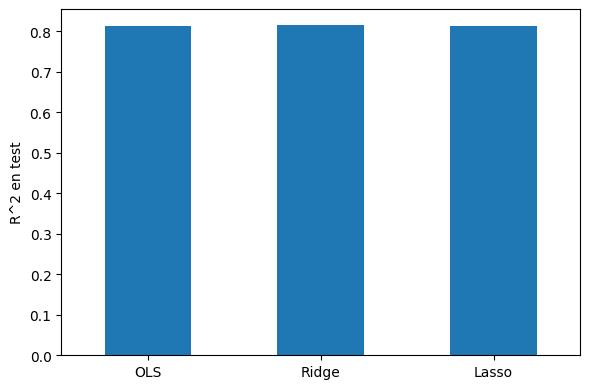

In [37]:
ax = metrics_table["R2_test"].plot(kind="bar", figsize=(6,4))
ax.set_ylabel("R^2 en test")
ax.setTitle = ("Comparación de R^2 en test: OLS vs Ridge vs Lasso")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 9.8 Trayectorias de coeficientes (paths) para Ridge y Lasso

Para visualizar cómo actúa la penalización, observamos la evolución de los coeficientes al variar $\alpha$.


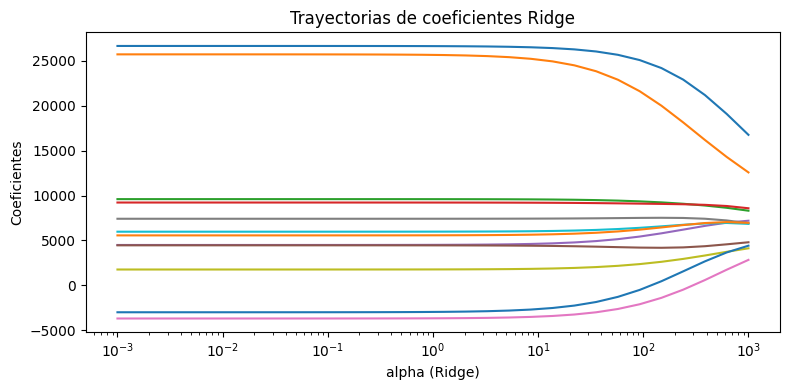

In [38]:
# Trayectoria de coeficientes para Ridge
alphas_ridge_path = np.logspace(-3, 3, 30)
coefs_ridge_path = []

for a in alphas_ridge_path:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_scaled, y_train)
    coefs_ridge_path.append(ridge.coef_)

coefs_ridge_path = np.array(coefs_ridge_path)

plt.figure(figsize=(8,4))
for j in range(coefs_ridge_path.shape[1]):
    plt.plot(alphas_ridge_path, coefs_ridge_path[:, j])
plt.xscale("log")
plt.xlabel("alpha (Ridge)")
plt.ylabel("Coeficientes")
plt.title("Trayectorias de coeficientes Ridge")
plt.tight_layout()
plt.show()

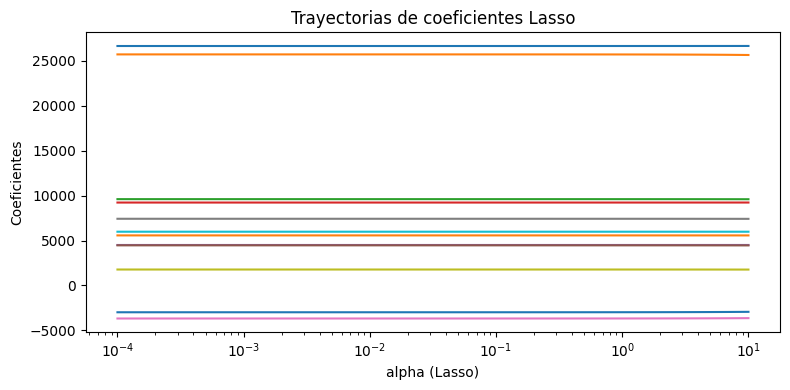

In [39]:
# Trayectoria de coeficientes para Lasso
alphas_lasso_path = np.logspace(-4, 1, 30)
coefs_lasso_path = []

for a in alphas_lasso_path:
    lasso = LassoCV(alphas=[a], cv=5, random_state=42, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    coefs_lasso_path.append(lasso.coef_)

coefs_lasso_path = np.array(coefs_lasso_path)

plt.figure(figsize=(8,4))
for j in range(coefs_lasso_path.shape[1]):
    plt.plot(alphas_lasso_path, coefs_lasso_path[:, j])
plt.xscale("log")
plt.xlabel("alpha (Lasso)")
plt.ylabel("Coeficientes")
plt.title("Trayectorias de coeficientes Lasso")
plt.tight_layout()
plt.show()

## 9.9 Key takeaways

- **Ridge** reduce la varianza de los coeficientes, especialmente en presencia de multicolinealidad, a costa de introducir sesgo controlado.  
- **Lasso** puede anular coeficientes (llevarlos exactamente a 0), realizando selección automática de variables.  
- La comparación de **RMSE** y **$R^2$** en el conjunto de prueba permite evaluar si la regularización mejora la capacidad de generalización frente al OLS clásico.  
- Las **trayectorias de coeficientes** ilustran cómo la penalización hace que los coeficientes se contraigan (Ridge) y se anulen (Lasso) al aumentar $\alpha$.  

En el siguiente capítulo se combinarán L1 y L2 mediante **ElasticNet**, y se construirá una comparación final de modelos.
